In [2]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import matplotlib.colors
import scipy.stats
import itertools
import string
import matplotlib.patches
import glob

import wrf
import netCDF4

import pandas

import matplotlib.ticker
import cartopy.mpl.gridliner #import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import mpl_toolkits
import cartopy

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

% matplotlib inline

In [3]:
run_info = 'FMAASO'
skip_time=0

# opening mean fields

## control data

In [4]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/400/ens_mean_wrfout_files'
cont_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [5]:
cont_p = cont_mfds['P']
cont_pb = cont_mfds['PB']
cont_ptot = cont_p + cont_pb

In [6]:
cont_qvapor = cont_mfds['QVAPOR']
cont_u = cont_mfds['U']
cont_v = cont_mfds['V']
cont_w = cont_mfds['W']

In [7]:
file_list = glob.glob(root_dir+'/'+'wrfout*.nc')
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [8]:
cont_ua = wrf.getvar(ds_list, 'ua', timeidx=wrf.ALL_TIMES)

In [9]:
cont_va = wrf.getvar(ds_list, 'va', timeidx=wrf.ALL_TIMES)

In [10]:
cont_qcloud = cont_mfds['QCLOUD']

In [11]:
cont_qrain = cont_mfds['QRAIN']

In [12]:
xlong = cont_mfds['XLONG'].values[0,:,:]
xlat = cont_mfds['XLAT'].values[0,:,:]

## phys data

In [13]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/ens_mean_wrfout_files'
phys_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [14]:
phys_p = phys_mfds['P']
phys_pb = phys_mfds['PB']
phys_ptot = phys_p + phys_pb

In [15]:
phys_p = phys_p.values

In [16]:
phys_qvapor = phys_mfds['QVAPOR']
phys_u = phys_mfds['U']
phys_v = phys_mfds['V']
phys_w = phys_mfds['W']

In [17]:
file_list = glob.glob(root_dir+'/'+'wrfout*.nc')
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [18]:
phys_ua = wrf.getvar(ds_list, 'ua', timeidx=wrf.ALL_TIMES)

In [19]:
phys_va = wrf.getvar(ds_list, 'va', timeidx=wrf.ALL_TIMES)

In [20]:
phys_qcloud = phys_mfds['QCLOUD']

In [21]:
phys_qrain = phys_mfds['QRAIN']

## example of longwave upward radiation at model top, converted to J/kg

## calculate omega at midpoints

# take means of pressure and winds below 860 hPa...

In [22]:
diff_ptot = phys_ptot-cont_ptot

In [23]:
cont_ptot = cont_ptot.values

In [24]:
diff_ptot_below860 = numpy.copy(diff_ptot)

In [25]:
diff_ua = phys_ua - cont_ua
diff_va = phys_va - cont_va

In [26]:
diff_ua_below860 = numpy.copy(diff_ua)

In [27]:
diff_ua_below900 = numpy.copy(diff_ua)

In [28]:
diff_va_below860 = numpy.copy(diff_va)

In [29]:
diff_va_below900 = numpy.copy(diff_va)

In [30]:
diff_ptot_below860[cont_ptot<86000.] = numpy.nan

In [31]:
diff_ua_below860[cont_ptot<86000.] = numpy.nan
diff_va_below860[cont_ptot<86000.] = numpy.nan

In [32]:
diff_ua_below900[cont_ptot<86000.] = numpy.nan
diff_va_below900[cont_ptot<86000.] = numpy.nan

In [33]:
diff_ptot_below860_vertmean = numpy.nanmean(diff_ptot_below860, axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [34]:
diff_ua_below860_vertmean = numpy.nanmean(diff_ua_below860, axis=1)
diff_va_below860_vertmean = numpy.nanmean(diff_va_below860, axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [35]:
diff_ua_below900_vertmean = numpy.nanmean(diff_ua_below900, axis=1)
diff_va_below900_vertmean = numpy.nanmean(diff_va_below900, axis=1)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


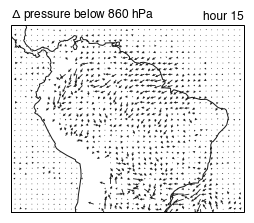

In [37]:
fontsize=12
lon_offset = 25.

diff_levels = numpy.arange(-.15,.151,0.025)

every_nth_lat=3
every_nth_lon=3
quiver_scale = 0.5 # 0.05 for 850-600, 0.1 for below 850
quiver_shaft_width = 0.2
quiver_key_scale = 3
quiver_color = '0.1'
quiver_head_length = 3
quiver_head_axis_length = quiver_head_length

for t in [15]:#range(48):#
    
    fig = mp.figure(figsize=(5,3))
    ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
    ax.set_extent([273,329,-30,15], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='0.1')
#     contour_plot = ax.pcolormesh(xlong,xlat,diff_ptot_below860_vertmean[t,:,:]/100., \
#                                  #levels=diff_levels, extend='both', \
#                                  vmin=diff_levels.min(),vmax=diff_levels.max(),\
#                                  cmap='RdBu')

    quiver_plot = ax.quiver(xlong[::every_nth_lat,::every_nth_lon], \
                            xlat[::every_nth_lat,::every_nth_lon], \
#                             diff_ua_below860_vertmean[t,::every_nth_lat,::every_nth_lon], \
#                             diff_va_below860_vertmean[t,::every_nth_lat,::every_nth_lon], \
                            diff_ua_below900_vertmean[t,::every_nth_lat,::every_nth_lon], \
                            diff_va_below900_vertmean[t,::every_nth_lat,::every_nth_lon], \
                            units='xy', scale=quiver_scale, width=quiver_shaft_width, \
                            color=quiver_color,\
                            headlength=quiver_head_length, \
                            headaxislength=quiver_head_axis_length, \
                            zorder=2)    

    ax.text(s="$\Delta$ pressure below 860 hPa", x=0, y=1.01,\
             ha='left', va='bottom', \
             transform=ax.transAxes, fontsize=fontsize)
    ax.text(s='hour '+'{:02d}'.format(t), x=1, y=1.01, \
             ha='right', va='bottom', transform=ax.transAxes, \
             fontsize=fontsize)
    
    fig.tight_layout()
    
    #ax.background_patch.set_facecolor('0.5')
    
    ax_pos = ax.get_position()
#     cbar = mp.colorbar(contour_plot)
#     cbar.ax.tick_params(labelsize=fontsize)
#     cbar.set_label('hPa', fontsize=fontsize)

    #fig.savefig('hourly_ptot_below860_change_hour'+ '{:02d}'.format(t)+'.png', dpi=600, bbox_inches='tight', transparent=True)
    #mp.close()

# calculate wind divergence

In [ ]:
cont_dudx = numpy.diff(cont_u, axis=3)/50000.
cont_dvdy = numpy.diff(cont_v, axis=2)/50000.

In [ ]:
phys_dudx = numpy.diff(phys_u, axis=3)/50000.
phys_dvdy = numpy.diff(phys_v, axis=2)/50000.

In [ ]:
diff_dudx = phys_dudx-cont_dudx
diff_dvdy = phys_dvdy-cont_dvdy

In [ ]:
diff_dudx_below860 = numpy.copy(diff_dudx)
diff_dvdy_below860 = numpy.copy(diff_dvdy)

In [ ]:
diff_dudx_below860[cont_ptot<86000.] = numpy.nan
diff_dvdy_below860[cont_ptot<86000.] = numpy.nan

In [ ]:
diff_dudx_below860.shape

In [ ]:
diff_dudx_below860_vertmean = numpy.nanmean(diff_dudx_below860, axis=1)
diff_dvdy_below860_vertmean = numpy.nanmean(diff_dvdy_below860, axis=1)

In [ ]:
diff_conv_below860_vertmean = -(diff_dudx_below860_vertmean+diff_dvdy_below860_vertmean)

In [ ]:
fontsize=12
lon_offset = 25.

diff_levels = numpy.arange(-.15,.151,0.025)

every_nth_lat=3
every_nth_lon=3
quiver_scale = 0.5 # 0.05 for 850-600, 0.1 for below 850
quiver_shaft_width = 0.2
quiver_key_scale = 3
quiver_color = '0.1'
quiver_head_length = 3
quiver_head_axis_length = quiver_head_length

for t in [18]:#range(48):#
    
    fig = mp.figure(figsize=(5,3))
    ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
    ax.set_extent([273,329,-30,15], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='0.1')
    contour_plot = ax.contourf(xlong,xlat,diff_conv_below860_vertmean[t,:,:], \
                                 #levels=diff_levels, extend='both', \
                                 #vmin=diff_levels.min(),vmax=diff_levels.max(),\
                                 cmap='RdBu')

    ax.text(s="$\Delta$ pressure below 860 hPa", x=0, y=1.01,\
             ha='left', va='bottom', \
             transform=ax.transAxes, fontsize=fontsize)
    ax.text(s='hour '+'{:02d}'.format(t), x=1, y=1.01, \
             ha='right', va='bottom', transform=ax.transAxes, \
             fontsize=fontsize)
    
    fig.tight_layout()
    
    #ax.background_patch.set_facecolor('0.5')
    
    ax_pos = ax1.get_position()
    cbar = mp.colorbar(contour_plot)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('hPa', fontsize=fontsize)

    #fig.savefig('hourly_ptot_below860_change_hour'+ '{:02d}'.format(t)+'.png', dpi=600, bbox_inches='tight', transparent=True)
    #mp.close()

## open omega (calculated from wrf-python)

In [ ]:
cont_omega = numpy.load('DATA_omega_400.npy')
phys_omega = numpy.load('DATA_omega_1000.npy')

## calculate finite differences for MSE, pressure

## take vertical integral by summing

# get landmask

In [146]:
landmask = cont_mfds['LANDMASK'].sel(Time=0).values
landmask_midpoints = landmask[1:,1:]

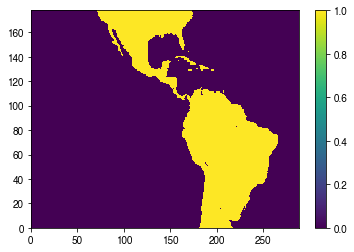

In [147]:
cf=mp.pcolormesh(landmask_midpoints);mp.colorbar(cf)

# calculate midpoints so that fields are 28x178x288

In [148]:
cont_u_midpoints = 0.5*(cont_u[:,:,:,1:]+cont_u[:,:,:,:-1])
cont_u_midpoints = 0.5*(cont_u_midpoints[:,1:,1:,1:]+cont_u_midpoints[:,:-1,:-1,:-1]).values

In [149]:
phys_u_midpoints = 0.5*(phys_u[:,:,:,1:]+phys_u[:,:,:,:-1])
phys_u_midpoints = 0.5*(phys_u_midpoints[:,1:,1:,1:]+phys_u_midpoints[:,:-1,:-1,:-1]).values

In [150]:
cont_v_midpoints = 0.5*(cont_v[:,:,1:,:]+cont_v[:,:,:-1,:])
cont_v_midpoints = 0.5*(cont_v_midpoints[:,1:,1:,1:]+cont_v_midpoints[:,:-1,:-1,:-1]).values

In [151]:
phys_v_midpoints = 0.5*(phys_v[:,:,1:,:]+phys_v[:,:,:-1,:])
phys_v_midpoints = 0.5*(phys_v_midpoints[:,1:,1:,1:]+phys_v_midpoints[:,:-1,:-1,:-1]).values

In [152]:
cont_p_midpoints = 0.5*(cont_p[:,1:,1:,1:]+cont_p[:,:-1,:-1,:-1])
phys_p_midpoints = 0.5*(phys_p[:,1:,1:,1:]+phys_p[:,:-1,:-1,:-1])

In [153]:
cont_qvapor_midpoints = 0.5*(cont_qvapor[:,1:,1:,1:]+cont_qvapor[:,:-1,:-1,:-1]).values
phys_qvapor_midpoints = 0.5*(phys_qvapor[:,1:,1:,1:]+phys_qvapor[:,:-1,:-1,:-1]).values

In [154]:
cont_qcloud_midpoints = 0.5*(cont_qcloud[:,1:,1:,1:]+cont_qcloud[:,:-1,:-1,:-1]).values
phys_qcloud_midpoints = 0.5*(phys_qcloud[:,1:,1:,1:]+phys_qcloud[:,:-1,:-1,:-1]).values

In [155]:
cont_qrain_midpoints = 0.5*(cont_qrain[:,1:,1:,1:]+cont_qrain[:,:-1,:-1,:-1]).values
phys_qrain_midpoints = 0.5*(phys_qrain[:,1:,1:,1:]+phys_qrain[:,:-1,:-1,:-1]).values

In [156]:
phys_ptot_midpoints = 0.5*(phys_ptot[:,1:,1:,1:]+phys_ptot[:,:-1,:-1,:-1]).values
cont_ptot_midpoints = 0.5*(cont_ptot[:,1:,1:,1:]+cont_ptot[:,:-1,:-1,:-1]).values

In [157]:
phys_ptot_diff = numpy.diff(phys_ptot.values, axis=1)
cont_ptot_diff = numpy.diff(cont_ptot.values, axis=1)

In [158]:
cont_omega_midpoints = (0.5*(cont_omega[:,1:,1:,1:]+cont_omega[:,:-1,:-1,:-1]))
phys_omega_midpoints = (0.5*(phys_omega[:,1:,1:,1:]+phys_omega[:,:-1,:-1,:-1]))

In [159]:
dx = 50000. # 50,000 m or 50 km
dy = 50000.

# calculate dqdt

In [160]:
ntime = 241
nlev = 28

In [161]:
cont_dqdt = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan
phys_dqdt = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan

In [162]:
for t in range(1,ntime-1):
    cont_dqdt[t,:,:,:] = (cont_qvapor_midpoints[t+1,:,:,:]-cont_qvapor_midpoints[t-1,:,:,:])/7200.
for t in range(1,ntime-1):
    phys_dqdt[t,:,:,:] = (phys_qvapor_midpoints[t+1,:,:,:]-phys_qvapor_midpoints[t-1,:,:,:])/7200.

# calculate dqcloud dt

In [163]:
cont_dqclouddt = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan
phys_dqclouddt = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan

In [164]:
for t in range(1,ntime-1):
    cont_dqclouddt[t,:,:,:] = (cont_qcloud_midpoints[t+1,:,:,:]-cont_qcloud_midpoints[t-1,:,:,:])/7200.
for t in range(1,ntime-1):
    phys_dqclouddt[t,:,:,:] = (phys_qcloud_midpoints[t+1,:,:,:]-phys_qcloud_midpoints[t-1,:,:,:])/7200.

# calculate dqraindt

In [165]:
cont_dqraindt = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan
phys_dqraindt = numpy.zeros((ntime,nlev,xlat.shape[0]-1,xlat.shape[1]-1))*numpy.nan

In [166]:
for t in range(1,ntime-1):
    cont_dqraindt[t,:,:,:] = (cont_qrain_midpoints[t+1,:,:,:]-cont_qrain_midpoints[t-1,:,:,:])/7200.
for t in range(1,ntime-1):
    phys_dqraindt[t,:,:,:] = (phys_qrain_midpoints[t+1,:,:,:]-phys_qrain_midpoints[t-1,:,:,:])/7200.

# calculate convergence

In [167]:
cont_dudx = numpy.diff(cont_u.values, axis=3)/dx
cont_dudx = 0.5*(cont_dudx[:,1:,1:,1:]+cont_dudx[:,:-1,:-1,:-1])

In [168]:
phys_dudx = numpy.diff(phys_u.values, axis=3)/dx
phys_dudx = 0.5*(phys_dudx[:,1:,1:,1:]+phys_dudx[:,:-1,:-1,:-1])

In [169]:
cont_dvdy = numpy.diff(cont_v.values, axis=2)/dy
cont_dvdy = 0.5*(cont_dvdy[:,1:,1:,1:]+cont_dvdy[:,:-1,:-1,:-1])

In [170]:
phys_dvdy = numpy.diff(phys_v.values, axis=2)/dy
phys_dvdy = 0.5*(phys_dvdy[:,1:,1:,1:]+phys_dvdy[:,:-1,:-1,:-1])

In [171]:
cont_domegadp = numpy.diff(cont_omega, axis=1)/cont_ptot_diff
cont_domegadp = 0.5*(cont_domegadp[:,:,1:,1:]+cont_domegadp[:,:,:-1,:-1])

In [172]:
phys_domegadp = numpy.diff(phys_omega, axis=1)/phys_ptot_diff
phys_domegadp = 0.5*(phys_domegadp[:,:,1:,1:]+phys_domegadp[:,:,:-1,:-1])

In [173]:
cont_convergence = -cont_qvapor_midpoints*(cont_dudx + cont_dvdy + cont_domegadp)

In [174]:
phys_convergence = -phys_qvapor_midpoints*(phys_dudx + phys_dvdy + phys_domegadp)

In [175]:
cont_vert_convergence = -cont_qvapor_midpoints*cont_domegadp

In [176]:
phys_vert_convergence = -phys_qvapor_midpoints*phys_domegadp

# calculate advection

In [177]:
cont_dqdx = numpy.diff(cont_qvapor.values, axis=3)/dx # diff in y, then take mean 
cont_dqdx = 0.5*(cont_dqdx[:,1:,1:,:]+cont_dqdx[:,:-1,:-1,:])

In [178]:
phys_dqdx = numpy.diff(phys_qvapor.values, axis=3)/dx # diff in y, then take mean 
phys_dqdx = 0.5*(phys_dqdx[:,1:,1:,:]+phys_dqdx[:,:-1,:-1,:])

In [179]:
cont_dqdy = numpy.diff(cont_qvapor.values, axis=2)/dy # diff in y, then take mean 
cont_dqdy = 0.5*(cont_dqdy[:,1:,:,1:]+cont_dqdy[:,:-1,:,:-1])

In [180]:
phys_dqdy = numpy.diff(phys_qvapor.values, axis=2)/dy # diff in y, then take mean 
phys_dqdy = 0.5*(phys_dqdy[:,1:,:,1:]+phys_dqdy[:,:-1,:,:-1])

In [181]:
cont_dqdp = numpy.diff(cont_qvapor.values, axis=1)/cont_ptot_diff
cont_dqdp = 0.5*(cont_dqdp[:,:,1:,1:]+cont_dqdp[:,:,:-1,:-1])

In [182]:
phys_dqdp = numpy.diff(phys_qvapor.values, axis=1)/phys_ptot_diff
phys_dqdp = 0.5*(phys_dqdp[:,:,1:,1:]+phys_dqdp[:,:,:-1,:-1])

In [183]:
cont_advection = -(cont_u_midpoints*cont_dqdx + cont_v_midpoints*cont_dqdy + cont_omega_midpoints*cont_dqdp)
phys_advection = -(phys_u_midpoints*phys_dqdx + phys_v_midpoints*phys_dqdy + phys_omega_midpoints*phys_dqdp)

In [184]:
cont_vert_advection = -(cont_omega_midpoints*cont_dqdp)
phys_vert_advection = -(phys_omega_midpoints*phys_dqdp)

# set ocean points to nan

# calculate time means

In [185]:
cont_p_tm = numpy.nanmean(cont_p, axis=0)
phys_p_tm = numpy.nanmean(phys_p, axis=0)

In [186]:
cont_dqdt_tm = numpy.nanmean(cont_dqdt, axis=0)
phys_dqdt_tm = numpy.nanmean(phys_dqdt, axis=0)

In [187]:
cont_dqclouddt_tm = numpy.nanmean(cont_dqclouddt, axis=0)
phys_dqclouddt_tm = numpy.nanmean(phys_dqclouddt, axis=0)

In [188]:
cont_dqraindt_tm = numpy.nanmean(cont_dqraindt, axis=0)
phys_dqraindt_tm = numpy.nanmean(phys_dqraindt, axis=0)

In [189]:
cont_advection_tm = numpy.nanmean(cont_advection, axis=0)
phys_advection_tm = numpy.nanmean(phys_advection, axis=0)

cont_vert_advection_tm = numpy.nanmean(cont_vert_advection, axis=0)
phys_vert_advection_tm = numpy.nanmean(phys_vert_advection, axis=0)

In [190]:
cont_convergence_tm = numpy.nanmean(cont_convergence, axis=0)
phys_convergence_tm = numpy.nanmean(phys_convergence, axis=0)

cont_vert_convergence_tm = numpy.nanmean(cont_vert_convergence, axis=0)
phys_vert_convergence_tm = numpy.nanmean(phys_vert_convergence, axis=0)

In [191]:
cont_omega_tm = numpy.nanmean(cont_omega_midpoints, axis=0)
phys_omega_tm = numpy.nanmean(phys_omega_midpoints, axis=0)

cont_omega_tm_day1 = numpy.nanmean(cont_omega_midpoints[:24,:,:,:], axis=0)
phys_omega_tm_day1 = numpy.nanmean(phys_omega_midpoints[:24,:,:,:], axis=0)

In [192]:
cont_advection_tm_day1 = numpy.nanmean(cont_advection[:24,:,:,:], axis=0)
phys_advection_tm_day1 = numpy.nanmean(phys_advection[:24,:,:,:], axis=0)

cont_vert_advection_tm_day1 = numpy.nanmean(cont_vert_advection[:24,:,:,:], axis=0)
phys_vert_advection_tm_day1 = numpy.nanmean(phys_vert_advection[:24,:,:,:], axis=0)

## selecting dry area lat/lon

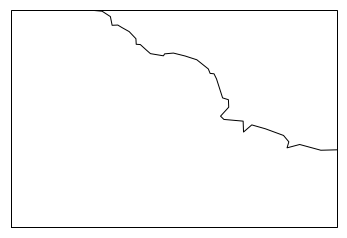

In [193]:
fig, ax = mp.subplots(1,1,subplot_kw={'projection':cartopy.crs.PlateCarree()})

ax.set_extent([xlong.min(),xlong.max(),xlat.min(),xlat.max()], crs=cartopy.crs.PlateCarree())
ax.set_extent([-70,-40,-10,10], crs=cartopy.crs.PlateCarree())
ax.coastlines()

## selecting wet area lat/lon

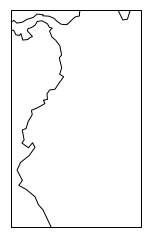

In [194]:
fig, ax = mp.subplots(1,1,subplot_kw={'projection':cartopy.crs.PlateCarree()})

ax.set_extent([xlong.min(),xlong.max(),xlat.min(),xlat.max()], crs=cartopy.crs.PlateCarree())
ax.set_extent([-82,-70,-10,10], crs=cartopy.crs.PlateCarree())
ax.coastlines()

In [195]:
dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -70,-40,-10,10
wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -82,-70,-10,10

In [196]:
xlat_midpoints = 0.5*(xlat[1:,1:]+xlat[:-1,:-1])
xlong_midpoints = 0.5*(xlong[1:,1:]+xlong[:-1,:-1])

In [197]:
wet_latlon_subset = ((xlat_midpoints<=wet_lat_hi) & (xlat_midpoints>=wet_lat_lo) \
                  & (xlong_midpoints<=wet_lon_hi) & (xlong_midpoints>=wet_lon_lo))

dry_latlon_subset = ((xlat_midpoints<=dry_lat_hi) & (xlat_midpoints>=dry_lat_lo) \
                  & (xlong_midpoints<=dry_lon_hi) & (xlong_midpoints>=dry_lon_lo))

lat_indices = ((xlat_midpoints<=10)&(xlat_midpoints>=-10))

In [198]:
cont_dqdt_wet_region = numpy.nanmean(cont_dqdt_tm[:,wet_latlon_subset], axis=1)
cont_dqdt_dry_region = numpy.nanmean(cont_dqdt_tm[:,dry_latlon_subset], axis=1)

phys_dqdt_wet_region = numpy.nanmean(phys_dqdt_tm[:,wet_latlon_subset], axis=1)
phys_dqdt_dry_region = numpy.nanmean(phys_dqdt_tm[:,dry_latlon_subset], axis=1)

In [199]:
cont_convergence_wet_region = numpy.nanmean(cont_convergence_tm[:,wet_latlon_subset], axis=1)
cont_convergence_dry_region = numpy.nanmean(cont_convergence_tm[:,dry_latlon_subset], axis=1)

phys_convergence_wet_region = numpy.nanmean(phys_convergence_tm[:,wet_latlon_subset], axis=1)
phys_convergence_dry_region = numpy.nanmean(phys_convergence_tm[:,dry_latlon_subset], axis=1)

cont_vert_convergence_wet_region = numpy.nanmean(cont_vert_convergence_tm[:,wet_latlon_subset], axis=1)
cont_vert_convergence_dry_region = numpy.nanmean(cont_vert_convergence_tm[:,dry_latlon_subset], axis=1)

phys_vert_convergence_wet_region = numpy.nanmean(phys_vert_convergence_tm[:,wet_latlon_subset], axis=1)
phys_vert_convergence_dry_region = numpy.nanmean(phys_vert_convergence_tm[:,dry_latlon_subset], axis=1)

In [200]:
cont_advection_wet_region = numpy.nanmean(cont_advection_tm[:,wet_latlon_subset], axis=1)
cont_advection_dry_region = numpy.nanmean(cont_advection_tm[:,dry_latlon_subset], axis=1)

phys_advection_wet_region = numpy.nanmean(phys_advection_tm[:,wet_latlon_subset], axis=1)
phys_advection_dry_region = numpy.nanmean(phys_advection_tm[:,dry_latlon_subset], axis=1)

cont_vert_advection_wet_region = numpy.nanmean(cont_vert_advection_tm[:,wet_latlon_subset], axis=1)
cont_vert_advection_dry_region = numpy.nanmean(cont_vert_advection_tm[:,dry_latlon_subset], axis=1)

phys_vert_advection_wet_region = numpy.nanmean(phys_vert_advection_tm[:,wet_latlon_subset], axis=1)
phys_vert_advection_dry_region = numpy.nanmean(phys_vert_advection_tm[:,dry_latlon_subset], axis=1)

In [201]:
cont_advection_wet_day1 = numpy.nanmean(cont_advection_tm_day1[:,wet_latlon_subset], axis=1)
cont_advection_dry_day1 = numpy.nanmean(cont_advection_tm_day1[:,dry_latlon_subset], axis=1)

phys_advection_wet_day1 = numpy.nanmean(phys_advection_tm_day1[:,wet_latlon_subset], axis=1)
phys_advection_dry_day1 = numpy.nanmean(phys_advection_tm_day1[:,dry_latlon_subset], axis=1)

cont_vert_advection_wet_day1 = numpy.nanmean(cont_vert_advection_tm_day1[:,wet_latlon_subset], axis=1)
cont_vert_advection_dry_day1 = numpy.nanmean(cont_vert_advection_tm_day1[:,dry_latlon_subset], axis=1)

phys_vert_advection_wet_day1 = numpy.nanmean(phys_vert_advection_tm_day1[:,wet_latlon_subset], axis=1)
phys_vert_advection_dry_day1 = numpy.nanmean(phys_vert_advection_tm_day1[:,dry_latlon_subset], axis=1)

In [202]:
cont_omega_wet = numpy.nanmean(cont_omega_tm[:,wet_latlon_subset],axis=1)
cont_omega_dry = numpy.nanmean(cont_omega_tm[:,dry_latlon_subset],axis=1)

phys_omega_wet = numpy.nanmean(phys_omega_tm[:,wet_latlon_subset],axis=1)
phys_omega_dry = numpy.nanmean(phys_omega_tm[:,dry_latlon_subset],axis=1)

In [203]:
cont_omega_wet_day1 = numpy.nanmean(cont_omega_tm_day1[:,wet_latlon_subset],axis=1)
cont_omega_dry_day1 = numpy.nanmean(cont_omega_tm_day1[:,dry_latlon_subset],axis=1)

phys_omega_wet_day1 = numpy.nanmean(phys_omega_tm_day1[:,wet_latlon_subset],axis=1)
phys_omega_dry_day1 = numpy.nanmean(phys_omega_tm_day1[:,dry_latlon_subset],axis=1)

# plot vertical changes using ptot change

In [204]:
cont_ptot_dry_region = numpy.nanmean(cont_ptot_midpoints[:,:,dry_latlon_subset], axis=(0,2))
cont_ptot_wet_region = numpy.nanmean(cont_ptot_midpoints[:,:,wet_latlon_subset], axis=(0,2))

In [205]:
diff_wet_region_dqdt = phys_dqdt_wet_region-cont_dqdt_wet_region
diff_dry_region_dqdt = phys_dqdt_dry_region-cont_dqdt_dry_region

In [206]:
diff_wet_region_conv = phys_convergence_wet_region-cont_convergence_wet_region
diff_dry_region_conv = phys_convergence_dry_region-cont_convergence_dry_region

In [207]:
diff_wet_region_adv = phys_advection_wet_region-cont_advection_wet_region
diff_dry_region_adv = phys_advection_dry_region-cont_advection_dry_region

## climatology

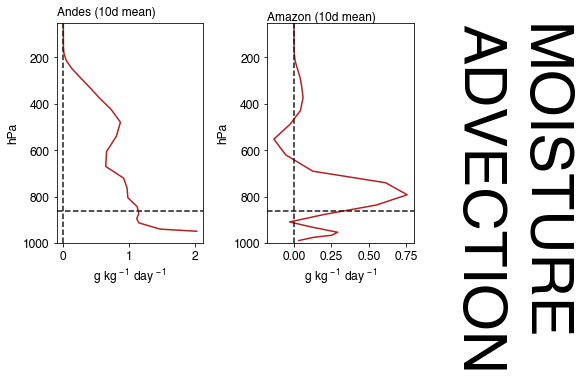

In [208]:
fontsize=12

fig = mp.figure(figsize=(6,4))

ax = fig.add_subplot(121)

ax.plot(cont_advection_wet_region*1000.*86400.,cont_ptot_wet_region/100., c='firebrick')
ax.axvline(0, ls='--', c='0.1')
ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,50)

ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

ax.text(s='Andes (10d mean)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)






ax = fig.add_subplot(122)

ax.plot(cont_advection_dry_region*1000.*86400.,cont_ptot_dry_region/100., c='firebrick')
ax.axvline(0, ls='--', c='0.1')
ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,50)

ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

ax.text(s='Amazon (10d mean)', x=0, y=1.0, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)

#ax.text(s='860\nhPa', x=0.0175, y=860, ha='left', va='center', fontsize=fontsize)

ax.text(s='MOISTURE\nADVECTION', x=1.25,y=1., ha='left', va='top', rotation=-90, transform=ax.transAxes,  fontsize=60)
fig.tight_layout()

fig.savefig('climatological_moisture_advection.png', dpi=600, transparent=True, bbox_inches='tight')

## add vertical advection only

In [209]:
diff_vert_wet_region_conv = phys_vert_convergence_wet_region-cont_vert_convergence_wet_region
diff_vert_dry_region_conv = phys_vert_convergence_dry_region-cont_vert_convergence_dry_region

In [210]:
diff_vert_wet_region_adv = phys_vert_advection_wet_region-cont_vert_advection_wet_region
diff_vert_dry_region_adv = phys_vert_advection_dry_region-cont_vert_advection_dry_region

In [211]:
diff_vert_wet_region_day1 = phys_vert_advection_wet_day1-cont_vert_advection_wet_day1
diff_vert_dry_region_day1 = phys_vert_advection_dry_day1-cont_vert_advection_dry_day1

diff_dry_region_day1 = phys_advection_dry_day1-cont_advection_dry_day1
diff_wet_region_day1 = phys_advection_wet_day1-cont_advection_wet_day1

In [212]:
omega_diff_wet_region = phys_omega_wet-cont_omega_wet
omega_diff_dry_region = phys_omega_dry-cont_omega_dry

omega_diff_wet_region_day1 = phys_omega_wet_day1-cont_omega_wet_day1
omega_diff_dry_region_day1 = phys_omega_dry_day1-cont_omega_dry_day1

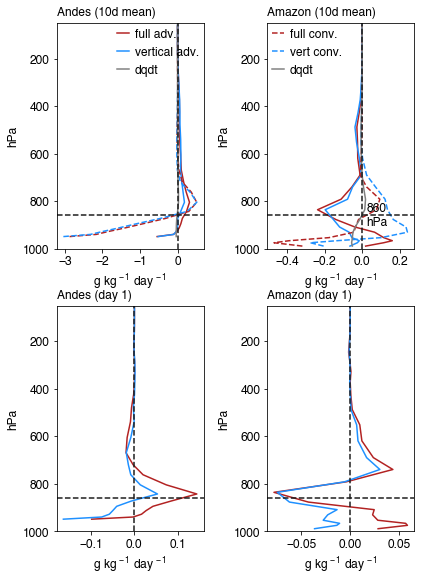

In [213]:
fontsize=12

fig = mp.figure(figsize=(6,8))

ax = fig.add_subplot(221)

ax.plot(diff_wet_region_adv*1000.*86400.,cont_ptot_wet_region/100., c='firebrick', label='full adv.')
ax.plot(diff_vert_wet_region_adv*1000.*86400.,cont_ptot_wet_region/100., c='dodgerblue', label='vertical adv.')

ax.plot(diff_wet_region_conv*1000.*86400.,cont_ptot_wet_region/100.,c='firebrick',ls='--')
ax.plot(diff_vert_wet_region_conv*1000.*86400.,cont_ptot_wet_region/100.,c='dodgerblue',ls='--')

ax.plot(diff_wet_region_dqdt*1000.*86400.,cont_ptot_wet_region/100.,c='0.5', label='dqdt')

ax.axvline(0, ls='--', c='0.1')
ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,50)

ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

ax.text(s='Andes (10d mean)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(0.99,0.99), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax.transAxes, loc='upper right', \
                   borderaxespad=0, borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)


ax = fig.add_subplot(222)

ax.plot(diff_dry_region_adv*1000.*86400.,cont_ptot_dry_region/100., c='firebrick')
ax.plot(diff_vert_dry_region_adv*1000.*86400.,cont_ptot_dry_region/100., c='dodgerblue')

ax.plot(diff_dry_region_conv*1000.*86400.,cont_ptot_dry_region/100.,c='firebrick',ls='--', label='full conv.')
ax.plot(diff_vert_dry_region_conv*1000.*86400.,cont_ptot_dry_region/100.,c='dodgerblue',ls='--', label='vert conv.')

ax.plot(diff_dry_region_dqdt*1000.*86400.,cont_ptot_dry_region/100.,c='0.5',label='dqdt')
ax.axvline(0, ls='--', c='0.1')
ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,50)

ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

ax.text(s='Amazon (10d mean)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)
ax.text(s='860\nhPa', x=0.023, y=860, ha='left', va='center', fontsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(0.01,0.99), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax.transAxes, loc='upper left', \
                   borderaxespad=0, borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)



ax = fig.add_subplot(223)

ax.plot(diff_wet_region_day1*1000.*86400.,cont_ptot_wet_region/100., c='firebrick', label='full')
ax.plot(diff_vert_wet_region_day1*1000.*86400.,cont_ptot_wet_region/100., c='dodgerblue', label='vertical')
ax.axvline(0, ls='--', c='0.1')
ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,50)

ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

ax.text(s='Andes (day 1)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)





ax = fig.add_subplot(224)

ax.plot(diff_dry_region_day1*1000.*86400.,cont_ptot_dry_region/100., c='firebrick')
ax.plot(diff_vert_dry_region_day1*1000.*86400.,cont_ptot_dry_region/100., c='dodgerblue')
ax.axvline(0, ls='--', c='0.1')
ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,50)

ax.tick_params(labelsize=fontsize)
ax.set_xlabel('g kg$^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

ax.text(s='Amazon (day 1)', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)


fig.tight_layout()

fig.savefig('mean_moisture_advection_10d_and_day1.png', dpi=600, transparent=True, bbox_inches='tight')

## plot omega vertical structure change

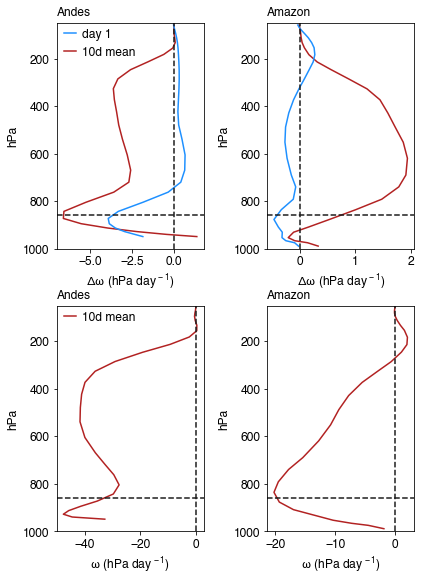

In [214]:
fontsize=12

fig = mp.figure(figsize=(6,8))

ax = fig.add_subplot(221)

ax.plot(omega_diff_wet_region*86400./100.,cont_ptot_wet_region/100., c='firebrick', label='10d mean')
ax.plot(omega_diff_wet_region_day1*86400./100.,cont_ptot_wet_region/100., c='dodgerblue', label='day 1')
ax.axvline(0, ls='--', c='0.1')
ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,50)

ax.tick_params(labelsize=fontsize)
ax.set_xlabel('$\Delta\omega$ (hPa day$^{\,-1}$)', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

ax.text(s='Andes', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]; labels=labels[::-1] # to reverse
legend = ax.legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(0.03,0.99), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax.transAxes, loc='upper left', \
                   borderaxespad=0, borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)






ax = fig.add_subplot(222)

ax.plot(omega_diff_dry_region*86400./100.,cont_ptot_dry_region/100., c='firebrick')
ax.plot(omega_diff_dry_region_day1*86400./100.,cont_ptot_dry_region/100., c='dodgerblue')
ax.axvline(0, ls='--', c='0.1')
ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,50)

ax.tick_params(labelsize=fontsize)
ax.set_xlabel('$\Delta\omega$ (hPa day$^{\,-1}$)', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

ax.text(s='Amazon', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)





ax = fig.add_subplot(223)

ax.plot(cont_omega_wet*86400./100.,cont_ptot_wet_region/100., c='firebrick', label='10d mean')
ax.axvline(0, ls='--', c='0.1')
ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,50)

ax.tick_params(labelsize=fontsize)
ax.set_xlabel('$\omega$ (hPa day$^{\,-1}$)', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

ax.text(s='Andes', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)

handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]; labels=labels[::-1] # to reverse
legend = ax.legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(0.03,0.99), edgecolor='None', \
                   facecolor='None', fancybox=False, bbox_transform=ax.transAxes, loc='upper left', \
                   borderaxespad=0, borderpad=0.25, handlelength=1.0, handletextpad=0.5, \
                   columnspacing=0.5, markerscale=1)






ax = fig.add_subplot(224)

ax.plot(cont_omega_dry*86400./100.,cont_ptot_dry_region/100., c='firebrick')
ax.axvline(0, ls='--', c='0.1')
ax.axhline(860, ls='--', c='0.1')
ax.set_ylim(1000,50)

ax.tick_params(labelsize=fontsize)
ax.set_xlabel('$\omega$ (hPa day$^{\,-1}$)', fontsize=fontsize)
ax.set_ylabel('hPa', fontsize=fontsize)

ax.text(s='Amazon', x=0, y=1.02, ha='left', va='bottom', transform=ax.transAxes, fontsize=fontsize)


fig.tight_layout()

fig.savefig('vertical_velocity_andes_amazon.png', dpi=600, transparent=True, bbox_inches='tight')

# hourly vertical profile plots

In [215]:
cont_p_lat_subset = cont_p_midpoints[:,:,lat_indices[:,0],:]
phys_p_lat_subset = phys_p_midpoints[:,:,lat_indices[:,0],:]

In [216]:
cont_advection_lat_subset = cont_advection[:,:,lat_indices[:,0],:]
phys_advection_lat_subset = phys_advection[:,:,lat_indices[:,0],:]

cont_convergence_lat_subset = cont_convergence[:,:,lat_indices[:,0],:]
phys_convergence_lat_subset = phys_convergence[:,:,lat_indices[:,0],:]

In [217]:
cont_adv_latmean = numpy.nanmean(cont_advection_lat_subset, axis=2)
phys_adv_latmean = numpy.nanmean(phys_advection_lat_subset, axis=2)

cont_conv_latmean = numpy.nanmean(cont_convergence_lat_subset, axis=2)
phys_conv_latmean = numpy.nanmean(phys_convergence_lat_subset, axis=2)

In [218]:
cont_dqdt_lat_subset = cont_dqdt[:,:,lat_indices[:,0],:]
phys_dqdt_lat_subset = phys_dqdt[:,:,lat_indices[:,0],:]

In [219]:
cont_dqclouddt_lat_subset = cont_dqclouddt[:,:,lat_indices[:,0],:]
phys_dqclouddt_lat_subset = phys_dqclouddt[:,:,lat_indices[:,0],:]

In [220]:
cont_dqraindt_lat_subset = cont_dqraindt[:,:,lat_indices[:,0],:]
phys_dqraindt_lat_subset = phys_dqraindt[:,:,lat_indices[:,0],:]

# lat means

In [221]:
cont_p_latmean = numpy.nanmean(cont_p_lat_subset, axis=2)
phys_p_latmean = numpy.nanmean(phys_p_lat_subset, axis=2)

In [222]:
cont_dqdt_latmean = numpy.nanmean(cont_dqdt_lat_subset, axis=2)
phys_dqdt_latmean = numpy.nanmean(phys_dqdt_lat_subset, axis=2)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [223]:
cont_dqclouddt_latmean = numpy.nanmean(cont_dqclouddt_lat_subset, axis=2)
phys_dqclouddt_latmean = numpy.nanmean(phys_dqclouddt_lat_subset, axis=2)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [224]:
cont_dqraindt_latmean = numpy.nanmean(cont_dqraindt_lat_subset, axis=2)
phys_dqraindt_latmean = numpy.nanmean(phys_dqraindt_lat_subset, axis=2)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [225]:
cont_ptot_midpoints_lat_subset = cont_ptot_midpoints[:,:,lat_indices[:,0],:]
cont_ptot_midpoints_latmean = numpy.nanmean(cont_ptot_midpoints_lat_subset, axis=2)

In [226]:
xx,zz=numpy.meshgrid(xlong_midpoints[0,:],cont_ptot_midpoints[0,:,:,0].mean(axis=1))

In [227]:
diff_adv_latmean = phys_adv_latmean-cont_adv_latmean
diff_conv_latmean = phys_conv_latmean-cont_conv_latmean
diff_dqdt_latmean = phys_dqdt_latmean-cont_dqdt_latmean
diff_dqclouddt_latmean = phys_dqclouddt_latmean-cont_dqclouddt_latmean
diff_dqraindt_latmean = phys_dqraindt_latmean-cont_dqraindt_latmean

## with residuals and qcloud and qrain

In [229]:
#cf=mp.contourf(xx+360.,cont_ptot_midpoints_latmean[10,:,:]/100.,cont_adv_latmean[10,:,:]*86400.*1000., cmap='RdBu', levels=numpy.arange(-10,11,2));mp.colorbar(cf)

fontsize = 12

xticks_deg_E=numpy.array((280,300,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

t = 24

for t in range(48):
    
    fig = mp.figure(figsize=(8.5,7.5))
    
    ax = fig.add_subplot(321)
    ax.set_ylim(1000,700)

    ax.set_facecolor('0.1')
    contour1 = ax.contourf(xx+360.,cont_ptot_midpoints_latmean[t,:,:]/100.,\
                diff_dqdt_latmean[t,:,:]*86400.*1000., \
                levels=numpy.arange(-3,3.1,0.5), \
                cmap='RdBu', \
                extend='both')
    ax.tick_params(labelsize=fontsize)
    ax.set_ylim(1000,700)
    ax.set_yticks([700,800,900,1000])
    ax.set_xlim(xlong.min()+55.+360.,xlong.max()+360.)
    ax.set_xticks([280,300,320])
    ax.set_xticklabels(xticks_format)
    ax.set_ylabel('hPa', fontsize=fontsize)
    cbar = mp.colorbar(contour1)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('g $kg^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
    ax.set_title('dqdt', fontsize=fontsize)
    
    
    ax = fig.add_subplot(322)
    ax.set_ylim(1000,700)
    ax.set_facecolor('0.1')

    contour2 = ax.contourf(xx+360.,cont_ptot_midpoints_latmean[t,:,:]/100.,\
                diff_conv_latmean[t,:,:]*86400.*1000., \
                levels=numpy.arange(-3,4,0.5),\
                cmap='RdBu', \
                extend='both')
    ax.tick_params(labelsize=fontsize)
    ax.set_ylim(1000,700)
    ax.set_yticks([700,800,900,1000])
    ax.set_xlim(xlong.min()+55.+360.,xlong.max()+360.)
    cbar = mp.colorbar(contour2)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('g $kg^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
    ax.set_xticks([280,300,320])
    ax.set_xticklabels(xticks_format)
    ax.set_ylabel('hPa', fontsize=fontsize)
    ax.set_title('convergence', fontsize=fontsize)



    ax = fig.add_subplot(323)
    ax.set_ylim(1000,700)
    ax.set_facecolor('0.1')

    contour3 = ax.contourf(xx+360.,cont_ptot_midpoints_latmean[t,:,:]/100.,\
                diff_adv_latmean[t,:,:]*86400.*1000., \
                levels=numpy.arange(-3,3.1,0.5), \
                cmap='RdBu', \
                extend='both')
    ax.tick_params(labelsize=fontsize)
    ax.set_ylim(1000,700)
    ax.set_yticks([700,800,900,1000])
    ax.set_xlim(xlong.min()+55.+360.,xlong.max()+360.)
    cbar = mp.colorbar(contour3)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('g $kg^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
    ax.set_xticks([280,300,320])
    ax.set_xticklabels(xticks_format)
    ax.set_ylabel('hPa', fontsize=fontsize)
    ax.set_title('advection', fontsize=fontsize)



    ax = fig.add_subplot(324)
    ax.set_ylim(1000,700)
    ax.set_facecolor('0.1')

    contour4 = ax.contourf(xx+360.,cont_ptot_midpoints_latmean[t,:,:]/100.,\
                diff_dqclouddt_latmean[t,:,:]*86400.*1000., \
                levels=numpy.arange(-3,3.1,0.5), \
                cmap='RdBu', \
                extend='both')
    ax.tick_params(labelsize=fontsize)
    ax.set_ylim(1000,700)
    ax.set_yticks([700,800,900,1000])
    ax.set_xlim(xlong.min()+55.+360.,xlong.max()+360.)
    cbar = mp.colorbar(contour4)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('g $kg^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
    ax.set_xticks([280,300,320])
    ax.set_xticklabels(xticks_format)
    ax.set_ylabel('hPa', fontsize=fontsize)
    ax.set_title('dqdt for clouds', fontsize=fontsize)


    ax = fig.add_subplot(325)
    ax.set_ylim(1000,700)
    ax.set_facecolor('0.1')

    contour5 = ax.contourf(xx+360.,cont_ptot_midpoints_latmean[t,:,:]/100.,\
                diff_dqraindt_latmean[t,:,:]*86400.*1000., \
                levels=numpy.arange(-3,3.1,0.5), \
                cmap='RdBu', \
                extend='both')
    ax.tick_params(labelsize=fontsize)
    ax.set_ylim(1000,700)
    ax.set_yticks([700,800,900,1000])
    ax.set_xlim(xlong.min()+55.+360.,xlong.max()+360.)
    cbar = mp.colorbar(contour5)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('g $kg^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
    ax.set_xticks([280,300,320])
    ax.set_xticklabels(xticks_format)
    ax.set_ylabel('hPa', fontsize=fontsize)
    ax.set_title('dqdt for rain', fontsize=fontsize)
    
    ax = fig.add_subplot(326)
    ax.set_ylim(1000,700)
    ax.set_facecolor('0.1')

    contour6 = ax.contourf(xx+360.,cont_ptot_midpoints_latmean[t,:,:]/100.,\
                (diff_dqdt_latmean[t,:,:]-(diff_adv_latmean[t,:,:]+\
                                           diff_conv_latmean[t,:,:]+\
                                           diff_dqclouddt_latmean[t,:,:]+\
                                           diff_dqraindt_latmean[t,:,:]))*86400.*1000., \
                levels=numpy.arange(-3,3.1,0.5), \
                cmap='RdBu', \
                extend='both')
    ax.tick_params(labelsize=fontsize)
    ax.set_ylim(1000,700)
    ax.set_yticks([700,800,900,1000])
    ax.set_xlim(xlong.min()+55.+360.,xlong.max()+360.)
    cbar = mp.colorbar(contour4)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('g $kg^{\,-1}$ day$^{\,-1}$', fontsize=fontsize)
    ax.set_xticks([280,300,320])
    ax.set_xticklabels(xticks_format)
    ax.set_ylabel('hPa', fontsize=fontsize)
    ax.set_title('residual', fontsize=fontsize)

    
    
    fig.text(s='hour '+'{:02d}'.format(t+1), x=0.5, y=1., weight='bold', ha='center', transform=fig.transFigure, fontsize=fontsize)
    
    fig.tight_layout()
    fig.savefig('dqdt_convergence_advection_hour'+'{:03d}'.format(t+1)+'.png', dpi=600, bbox_inches='tight')
    
    mp.close()
    
    

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/export/home/blangenb/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


# what about perturbation pressure?

In [ ]:
diff_p_latmean = phys_p_latmean - cont_p_latmean

In [ ]:
fontsize = 12

xticks_deg_E=numpy.array((280,300,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

for t in range(48):
    
    fig = mp.figure(figsize=(4.25,2.5))
    
    ax = fig.add_subplot(111)
    ax.set_ylim(1000,500)

    ax.set_facecolor('0.1')
    contour1 = ax.contourf(xx+360.,cont_ptot_midpoints_latmean[t,:,:]/100.,\
                diff_p_latmean[t,:,:]/100., \
                levels=numpy.arange(-0.4,0.41,0.05), \
                cmap='RdBu', \
                extend='both')
    ax.tick_params(labelsize=fontsize)
    ax.set_ylim(1000,700)
    ax.set_yticks([500,600,700,800,900,1000])
    ax.set_xlim(xlong.min()+55.+360.,xlong.max()+360.)
    ax.set_xticks([280,300,320])
    ax.set_xticklabels(xticks_format)
    ax.set_ylabel('hPa', fontsize=fontsize)
    cbar = mp.colorbar(contour1)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('hPa', fontsize=fontsize)
    ax.set_title('pert. pressure', fontsize=fontsize)
    
    fig.text(s='hour '+'{:02d}'.format(t+1), x=0.5, y=1., weight='bold', ha='center', transform=fig.transFigure, fontsize=fontsize)
    
    fig.tight_layout()
    fig.savefig('p_pert_hour'+'{:03d}'.format(t+1)+'.png', dpi=600, bbox_inches='tight')
    
    mp.close()